[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/breakpoints.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239469-lesson-2-breakpoints)



# 断点（Breakpoints）

## 评审（Review）

For `human-in-the-loop`, we often want to see our graph outputs as its running. 

对于 `human-in-the-loop`，我们通常希望在它运行时查看图形输出。

We laid the foundations for this with streaming. 

我们通过流式传输为此奠定了基础。

## 目标（Goals）

Now, let's talk about the motivations for `human-in-the-loop`:

现在，让我们来谈谈 `human-in-the-loop` 的动机：

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action
(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(2) `Debugging` - 我们可以回退图形以重现或避免问题

(3) `Editing` - You can modify the state 

(3) `Editing` - 您可以修改状态

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.

LangGraph 提供了多种获取或更新代理状态的方法，以支持各种 `human-in-the-loop` 工作流程。

First, we'll introduce [breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage), which provide a simple way to stop the graph at specific steps. 

首先，我们将介绍 [breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage)，它提供了一种在特定步骤停止图的简单方法。

We'll show how this enables user `approval`.

我们将展示这如何启用用户 `approval`。



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## 用于人类审批的断点（Breakpoints for human approval）

Let's re-consider the simple agent that we worked with in Module 1. 

让我们重新考虑我们在第1模块中研究的简单代理。

Let's assume that are concerned about tool use: we want to approve the agent to use any of its tools.
 
All we need to do is simply compile the graph with `interrupt_before=["tools"]` where `tools` is our tools node.

假设我们关注工具的使用：我们希望批准代理使用其任何工具。

我们所需要做的就是简单地用 `interrupt_before=["tools"]` 编译图形，其中 `tools` 是我们的工具节点。

This means that the execution will be interrupted before the node `tools`, which executes the tool call.

这意味着在执行工具调用的节点 `tools` 之前，执行将被中断。



In [1]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(
    model="qwen-plus-2025-04-28",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)
llm_with_tools = llm.bind_tools(tools)

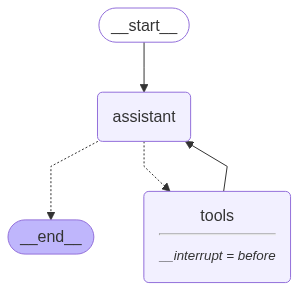

In [2]:
from IPython.display import Image, display


from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode


from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# 系统消息
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


# 节点
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# 图
builder = StateGraph(MessagesState)


# 定义节点：这些节点负责执行工作
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))


# 定义边：这些边决定了控制流程
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # 如果来自 assistant 的最新消息（结果）是工具调用 -> tools_condition 将路由到 tools
    # 如果来自 assistant 的最新消息（结果）不是工具调用 -> tools_condition 将路由到 END
    tools_condition,
)
builder.add_edge("tools", "assistant")


memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)


# 显示
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [3]:
# Input
initial_input = {"messages": HumanMessage(content="2乘3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

2乘3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_92a4bcf88d25476d925775)
 Call ID: call_92a4bcf88d25476d925775
  Args:
    a: 2
    b: 3


We can get the state and look at the next node to call.

我们可以获取状态并查看要调用的下一个节点。

This is a nice way to see that the graph has been interrupted.

这是一种很好的方法，可以发现图已被中断。



In [4]:
state = graph.get_state(thread)
state.next

('tools',)

Now, we'll introduce a nice trick.

现在，我们将介绍一个很好的技巧。

When we invoke the graph with `None`, it will just continue from the last state checkpoint!

当我们使用 `None` 调用图时，它将直接从最后一个状态检查点继续！

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

For clarity, LangGraph will re-emit the current state, which contains the `AIMessage` with tool call.

为清晰起见，LangGraph 将重新发出当前状态，其中包含带有工具调用的 `AIMessage`。

And then it will proceed to execute the following steps in the graph, which start with the tool node.

然后它将按照图形中的以下步骤继续执行，这些步骤从工具节点开始。

We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.

我们看到工具节点在此工具调用中运行，并将结果传递回聊天模型以获得最终答案。



In [5]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_92a4bcf88d25476d925775)
 Call ID: call_92a4bcf88d25476d925775
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2乘3的结果是6。


Now, lets bring these together with a specific user approval step that accepts user input.

现在，让我们通过一个特定的用户审批步骤将它们结合起来，该步骤接受用户输入。



In [ ]:
# 输入
initial_input = {"messages": HumanMessage(content="2乘3")}

# 线程
thread = {"configurable": {"thread_id": "2"}}

# 运行图直到第一次中断
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# 获取用户反馈
user_approval = input("你想使用工具吗? (yes/no): ")

# 检查是否批准
if user_approval.lower() == "yes":
    
    # 如果批准，则继续执行图
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("操作已取消。")


================================ Human Message =================================

2乘3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_1d98eba3a04d4386b6d2c7)
 Call ID: call_1d98eba3a04d4386b6d2c7
  Args:
    a: 2
    b: 3
Operation cancelled by user.


### 使用 LangGraph API 设置断点（Breakpoints with LangGraph API）

**⚠️ DISCLAIMER**

**⚠️ 免责声明**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

自从这些视频的拍摄以来，我们已经更新了 Studio，使其可以本地运行并在浏览器中打开。这是现在运行 Studio 的首选方式（而不是像视频中那样使用桌面应用程序）。请参阅有关 [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) 本地开发服务器的文档和 [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `/studio` 目录中，在终端运行以下命令：

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

你应该看到以下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

打开您的浏览器并导航到 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

The LangGraph API [supports breakpoints](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_breakpoint/#sdk-initialization). 

LangGraph API [supports breakpoints](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_breakpoint/#sdk-initialization).



In [1]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [2]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

As shown above, we can add `interrupt_before=["node"]` when compiling the graph that is running in Studio.

如上所示，我们在 Studio 中运行的图形编译时可以添加 `interrupt_before=["node"]`。

However, with the API, you can also pass `interrupt_before` to the stream method directly. 

然而，通过 API，您还可以直接将 `interrupt_before` 传递给流式方法。



In [10]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '2a3b1e7a-f6d9-44c2-a4b4-b7f67aa3691c', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_ElnkVOf1H80dlwZLqO0PQTwS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 't

Now, we can proceed from the breakpoint just like we did before by passing the `thread_id` and `None` as the input!

现在，我们可以通过传递 `thread_id` 和 `None` 作为输入，从断点继续执行，就像我们之前做的那样！



In [11]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_ElnkVOf1H80dlwZLqO0PQTwS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-89ee14dc-5f46-4dd9-91d9-e922c4a23572-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_ElnkVOf1H80dlwZLqO0PQTwS', 'type': 'tool_call'}], 'invalid_tool_